# Visualize the CSH measures

In [10]:
import pandas as pd
from datetime import timedelta, date, datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

## Read data from various sources

### CSH measures

In [11]:
measures = pd.read_csv('covid19-interventionmeasures/COVID19_non-pharmaceutical-interventions_version2_utf8.csv', delimiter=',',
                         parse_dates=['Date'], dayfirst=True, encoding='ISO-8859–1')

In [12]:
# define measure splits that will be plotted in three different plots / country
measure_sets = {
    1:['Case identification, contact tracing and related measures',
       'Travel restriction',
       'Social distancing'],
    2:['Risk communication',
       'Healthcare and public health capacity',
       'Resource allocation'],
    3:['Returning to normal life']
}

### Infection numbers

Data downloaded from the [John Hopkins GitHub repository](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series).

In [13]:
# global data on daily case and death numbers
infections = pd.read_csv('time_series_covid19_confirmed_global.csv')\
    .drop(columns=['Unnamed: 0', 'Lat', 'Long'])\
    .rename(columns={'Province/State':'State', 'Country/Region':'Country'})

# keep only country-wide infections
infections = infections[infections['State'].isna()].drop(columns=['State'])

# convert column timestamps to dates
for c in infections.columns[1:]:
    infections = infections.rename(columns={c:pd.to_datetime(c).date()})

# rename countries to match the CSH naming
infections['Country'] = infections['Country'].replace({
    'Federation of Bosnia and Herzegovina':'Bosnia and Herzegovina',
    'Czechia': 'Czech Republic',
    'Taiwan*':'Taiwan',
    'US':'United States of America'   
})
    
# US data on daily case and death numbers
US_infections = pd.read_csv('time_series_covid19_confirmed_US.csv')\
    .rename(columns={'Province_State':'State', 'Country_Region':'Country'})
US_infections['Country'] ='United States of America'
US_infections['Country'] = US_infections['Country'] + '_' + US_infections['State']

US_infections = US_infections.drop(columns=['UID', 'iso2', 'iso3', 'code3',
                'FIPS', 'Admin2', 'Lat', 'Long_', 'Combined_Key', 'State'])

US_infections = US_infections.groupby('Country').sum().reset_index()

# convert column timestamps to dates
for c in US_infections.columns[1:]:
    US_infections = US_infections.rename(columns={c:pd.to_datetime(c).date()})

# combine country data with US state data
infections = pd.concat([infections, US_infections])

infections.index = infections['Country']
infections = infections.drop(columns=['Country']).transpose()

## Plotting functions

In [14]:
def PlotInfectionTimeSeries(data, ax, color):
    
    # set up date x-ticks
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.set_minor_locator(days)
    ax.format_xdata = mdates.DateFormatter('%y %m %d')

    # calculate the difference in confirmed cases from one day to the next
    cases = data.values[1:] - data.values[0:-1]
    dates = data.index.values[1:]
    
    # plot the cases
    ax.plot(dates, cases, marker='o', c=color, label='confirmed cases',
            lw=2, markersize=8, alpha=.35)

    # legend
    legend = ax.legend(loc=1, fontsize=8)
    ymax = ax.get_ylim()[1]
    
    return legend, ymax

In [15]:
def GetFontSize(N_measures):
    '''
    Calculates the font-size depending on the number of measures in the dataset
    '''
    if N_measures < 10:
        fsize=10
    elif N_measures < 15:
        fsize=9
    elif N_measures < 20:
        fsize=8
    elif N_measures < 25:
        fsize=7
    elif N_measures < 30:
        fsize=6
    elif N_measures < 35:
        fsize=5
    elif N_measures < 40:
        fsize=4
    elif N_measures < 45:
        fsize=3
    else:
        fsize=2
        
    return fsize

In [16]:
def PlotMeasures(data, ax, ymax):
    # constant shift that can be applied to measure dates, for example if
    # we assume a measure takes effect ~10 days after it's implementation and
    # want to visualize measure effect rather than announcement
    shift = 0
    
    # cutoff value: measures before this date will not be considered
    measure_date_cuoff = date(2020,1,20)
    
    # data wrangling
    data = data.reset_index(drop=True)
    data = data.sort_values('Date')
    
    N_measures = len(data)
    fsize = GetFontSize(N_measures) # get the font-size for the measure text
    
    # map of measure categories to colours
    measure_color_codes = {'Case identification, contact tracing and related measures':'Green',
                       'Travel restriction':'MediumBlue', 
                       'Social distancing':'FireBrick',
                       'Risk communication':'DarkOrange',
                       'Healthcare and public health capacity':'HotPink', 
                       'Resource allocation':'DarkCyan',
                       'Returning to normal life':'black'}
    
    # plot a vertical line for each measure contained in the data set
    for k, row in data.iterrows():
        mdate = row['Date']
        mcolor = measure_color_codes[row['Measure_L1']]
        
        if mdate < measure_date_cuoff:
            continue

        
        if row['Measure_L3'] != row['Measure_L3']: # nan-check
            measuretext = row['Measure_L2']
        else:
            measuretext = row['Measure_L2'] + ': ' + row['Measure_L3']
            
        if measuretext != measuretext: # nan-check
            continue
        
        # shorten measure name string if it is too long
        if len(measuretext) > 100:
            measuretext = measuretext[0:100] + '...'
        
        # Calculate the vertical position of the measure name in the plot:
        # This shifts measures that were implemented later in time upwards.
        # The shift is calculated such that measures are evenly distributed
        # over the available vertical space
        textlevel = ymax * 0.1 + k * ((ymax - ymax * 0.1) / N_measures)
        
        # plot a vertical line at the date associated with the measure
        ax.plot([mdate + timedelta(days=shift), mdate + timedelta(days=shift)],
                [0, ymax + 0.1 * ymax], '--', color=mcolor, 
                lw=0.5, alpha=1, dashes=(5,10))
        
        # plot the measure description text next to the measure
        ax.text(mdate + timedelta(days=shift + 0.5), textlevel, measuretext,
                fontsize=fsize, color=mcolor)

    # compose the legend
    custom_lines = [Line2D([0], [0], color=measure_color_codes[measure], lw=2)
                   for measure in data['Measure_L1'].unique()]
    legend = ax.legend(custom_lines, data['Measure_L1'].unique(),
                        loc='best', fontsize=8)
    
    return legend

In [25]:
def MakePlot(country, countr_infections, country_measures, color, j):
    
    fig, ax = plt.subplots(figsize=(10, 4.5))
    legend1, ymax = PlotInfectionTimeSeries(country_infections, ax, color)
    legend2 = PlotMeasures(country_measures, ax, ymax)
    
    ax.add_artist(legend1)
    ax.add_artist(legend2)

    ax.tick_params(labelrotation=90, labelsize=8)
    ax.set_title(country, fontsize = 20)
    ax.set_ylim([- 0.05* ymax, 0.1*ymax + ymax])
    ax.set_xlim([datetime.strptime('1/20/20','%m/%d/%y'),\
                 datetime.strptime('12/01/20','%m/%d/%y')])
    
    ax.set_ylabel('daily new cases')

    fig.tight_layout()
    plt.savefig('results/measure_overview_CSH_{}_{}.svg'.format(country, j))
    plt.savefig('results/measure_overview_CSH_{}_{}.pdf'.format(country, j))
    plt.savefig('results/measure_overview_CSH_{}_{}.png'.format(country, j),
                dpi=150)

    plt.show()


## Make visualizations

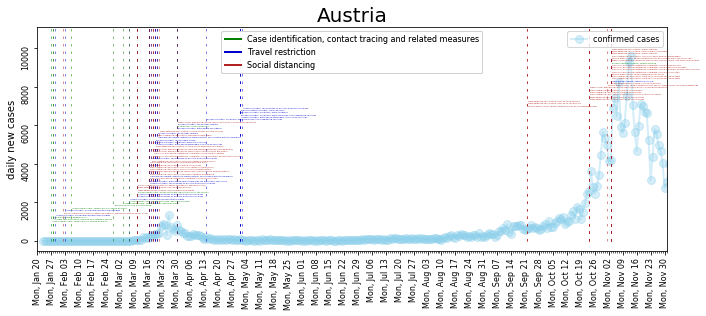

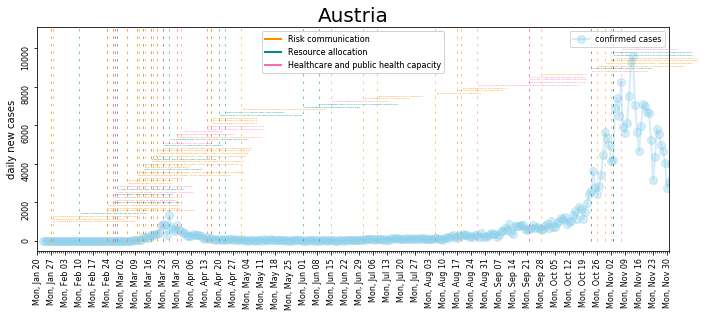

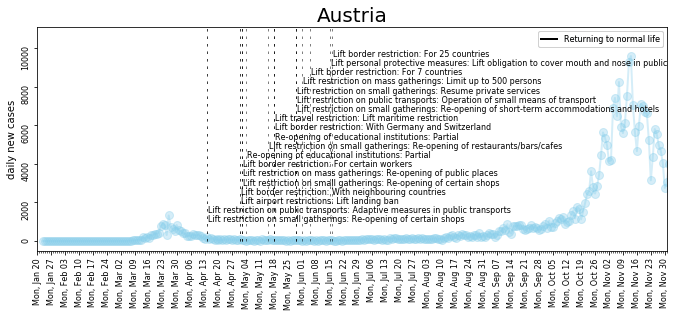

In [26]:
days     = mdates.DayLocator()
weeks    = mdates.WeekdayLocator(byweekday = mdates.MO)
date_fmt = mdates.DateFormatter('%a, %b %d')
color = 'SkyBlue'

country = 'Austria'
state = 'Wyoming'
    
# selection country infection data
country_infections = infections[country]

# selection country measure data
if not country == 'United States of America':
    # drop all measures that are not country-wide for all countries except the US
    country_measures = measures[measures['Country'] == country]
    country_measures = country_measures[\
            country_measures['Region'] == country]
else:
    country_measures = measures[\
            measures['State'] == state]
    country = '{}_{}'.format(country, state)

# iterate over the pre-defined measure sets
for i, measure_set in measure_sets.items():
    country_measure_subset = country_measures[\
                             country_measures['Measure_L1'].isin(measure_set)]

    if len(country_measure_subset) > 0:
        MakePlot(country, country_infections, country_measure_subset, color, i)
    else:
            print('No measures detected for country '+\
                  '{} measures split {}'.format(country, i))

plt.show()